In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

plt.rcParams['font.family'] = 'Malgun Gothic'
warnings.filterwarnings('ignore')

df_info_org = pd.read_csv('./data/big_data_set1_f.csv', encoding='cp949')
df_sales_org = pd.read_csv('./data/big_data_set2_f.csv', encoding='cp949')
df_customer_org = pd.read_csv('./data/big_data_set3_f.csv', encoding='cp949')

df_info = pd.read_csv('./data/big_data_set1_f.csv', encoding='cp949')
df_sales = pd.read_csv('./data/big_data_set2_f.csv', encoding='cp949')
df_customer = pd.read_csv('./data/big_data_set3_f.csv', encoding='cp949')


한글명으로 칼럼 변경

In [2]:
column_mapper1 = {
    'ENCODED_MCT': '가맹점구분번호',
    'MCT_BSE_AR': '가맹점주소',
    'MCT_NM': '가맹점명',
    'MCT_BRD_NUM': '브랜드구분코드',
    'MCT_SIGUNGU_NM': '가맹점지역',
    'HPSN_MCT_ZCD_NM': '업종',
    'HPSN_MCT_BZN_CD_NM': '상권',
    'ARE_D': '개설일',
    'MCT_ME_D': '폐업일'
}

column_mapper2 = {
    'ENCODED_MCT': '가맹점구분번호',
    'TA_YM': '기준년월',
    'MCT_OPE_MS_CN': '가맹점 운영개월 수 구간',
    'RC_M1_SAA': '매출금액 구간',
    'RC_M1_TO_UE_CT': '매출건 수 구간',
    'RC_M1_UE_CUS_CN': '유니크 고객 수 구간',
    'RC_M1_AV_NP_AT': '객단가 구간',
    'APV_CE_RAT': '취소율 구간',
    'DLV_SAA_RAT': '배달매출금액 비율',
    'M1_SME_RY_SAA_RAT': '동일 업종 매출금액 비율',
    'M1_SME_RY_CNT_RAT': '동일 업종 매출건수 비율',
    'M12_SME_RY_SAA_PCE_RT': '동일 업종 내 매출 순위 비율',
    'M12_SME_BZN_SAA_PCE_RT': '동일 상권 내 매출 순위 비율',
    'M12_SME_RY_ME_MCT_RAT': '동일 업종 내 해지 가맹점 비중',
    'M12_SME_BZN_ME_MCT_RAT': '동일 상권 내 해지 가맹점 비중'
}

column_mapper3 = {
    'ENCODED_MCT': '가맹점구분번호',
    'TA_YM': '기준년월',
    'M12_MAL_1020_RAT': '남성 20대이하 고객 비중',
    'M12_MAL_30_RAT': '남성 30대 고객 비중',
    'M12_MAL_40_RAT': '남성 40대 고객 비중',
    'M12_MAL_50_RAT': '남성 50대 고객 비중',
    'M12_MAL_60_RAT': '남성 60대이상 고객 비중',
    'M12_FME_1020_RAT': '여성 20대이하 고객 비중',
    'M12_FME_30_RAT': '여성 30대 고객 비중',
    'M12_FME_40_RAT': '여성 40대 고객 비중',
    'M12_FME_50_RAT': '여성 50대 고객 비중',
    'M12_FME_60_RAT': '여성 60대이상 고객 비중',
    'MCT_UE_CLN_REU_RAT': '재방문 고객 비중',
    'MCT_UE_CLN_NEW_RAT': '신규 고객 비중',
    'RC_M1_SHC_RSD_UE_CLN_RAT': '거주 이용 고객 비율',
    'RC_M1_SHC_WP_UE_CLN_RAT': '직장 이용 고객 비율',
    'RC_M1_SHC_FLP_UE_CLN_RAT': '유동인구 이용 고객 비율'
}


df_info.rename(columns=column_mapper1, inplace=True)
df_sales.rename(columns=column_mapper2, inplace=True)
df_customer.rename(columns=column_mapper3, inplace=True)


In [ ]:
#공통된 값 삭제
df_info.drop('가맹점지역', axis=1, inplace=True)
df_info['프랜차이즈여부'] = df_info['브랜드구분코드'].notna().astype(int)
df_info.drop('브랜드구분코드', axis=1, inplace=True)

# 정규표현식 사용
pattern = r'^(서울(특별시)?\s*성동구)'
df_info = df_info[df_info['가맹점주소'].str.contains(pattern, na=False)]
df_info['가맹점주소'] = df_info['가맹점주소'].str.replace(r'^(서울(특별시)?\s*성동구\s*)', '', regex=True)


결측치 확인

<Axes: >

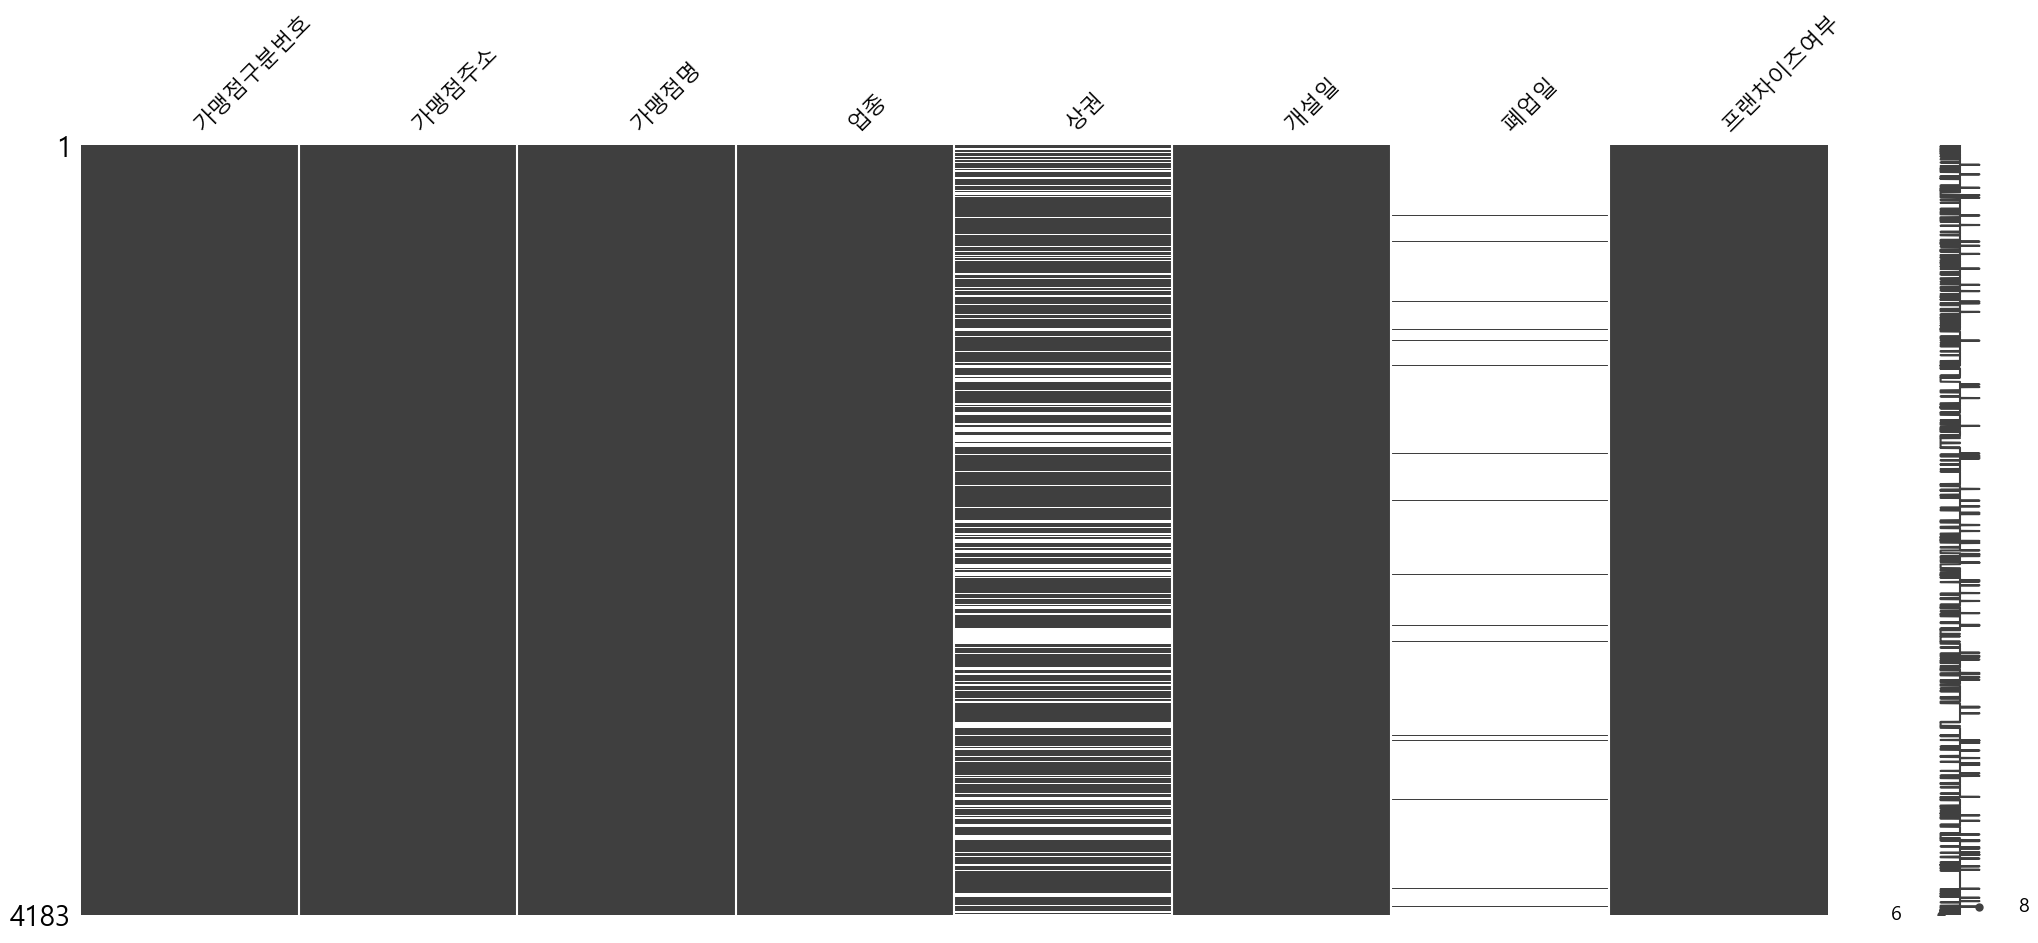

In [19]:
import missingno as msno
msno.matrix(df_info)

In [20]:
# 분석에 필요한 임시 컬럼('도로명', '도로명2') 미리 생성
df_info['도로명'] = df_info['가맹점주소'].str.split().str[0]
df_info['도로명2'] = df_info['도로명'].str.replace(r'\d.*', '', regex=True)

print(f"처리 전 결측값 개수: {df_info['상권'].isnull().sum()}")

# 1.'도로명' 기준 대표 상권으로 채우기
df_reference1 = df_info.dropna(subset=['상권'])
map1 = df_reference1.groupby('도로명')['상권'].agg(lambda x: x.mode()[0])
df_info['상권'].fillna(df_info['도로명'].map(map1), inplace=True)

print(f"1차 처리 후 남은 결측값 개수: {df_info['상권'].isnull().sum()}")

# 2.'도봉1로' -> '도봉'으로 도로명 이용해서 상권 채우기
df_reference2 = df_info.dropna(subset=['상권'])
map2 = df_reference2.groupby('도로명2')['상권'].agg(lambda x: x.mode()[0])
df_info['상권'].fillna(df_info['도로명2'].map(map2), inplace=True)

print(f"2차 처리 후 남은 결측값 개수: {df_info['상권'].isnull().sum()}")

# 3. '도로명2' 자체를 상권 이름으로 사용
df_info['상권'].fillna(df_info['도로명2'], inplace=True)
print(f"3차 처리 후 남은 결측값 개수: {df_info['상권'].isnull().sum()}")

# 임시 컬럼 모두 삭제 ---
df_info.drop(columns=['도로명', '도로명2'], inplace=True)

# --- 최종 결과 확인 ---
print("\n--- 최종 '상권' 컬럼 결측값 ---")
print(df_info['상권'].isnull().sum())

처리 전 결측값 개수: 1046
1차 처리 후 남은 결측값 개수: 380
2차 처리 후 남은 결측값 개수: 75
3차 처리 후 남은 결측값 개수: 0

--- 최종 '상권' 컬럼 결측값 ---
0


날짜 전처리

In [21]:
df_info['개설일'] = pd.to_datetime(df_info['개설일'], format='%Y%m%d', errors='coerce')
df_info['폐업일'] = df_info['폐업일'].astype(str).str.replace('\.0', '', regex=True)
df_info['폐업일'] = pd.to_datetime(df_info['폐업일'], format='%Y%m%d', errors='coerce')

df_sales['기준년월'] = pd.to_datetime(df_sales['기준년월'], format='%Y%m')
df_customer['기준년월'] = pd.to_datetime(df_customer['기준년월'], format='%Y%m')

<Axes: >

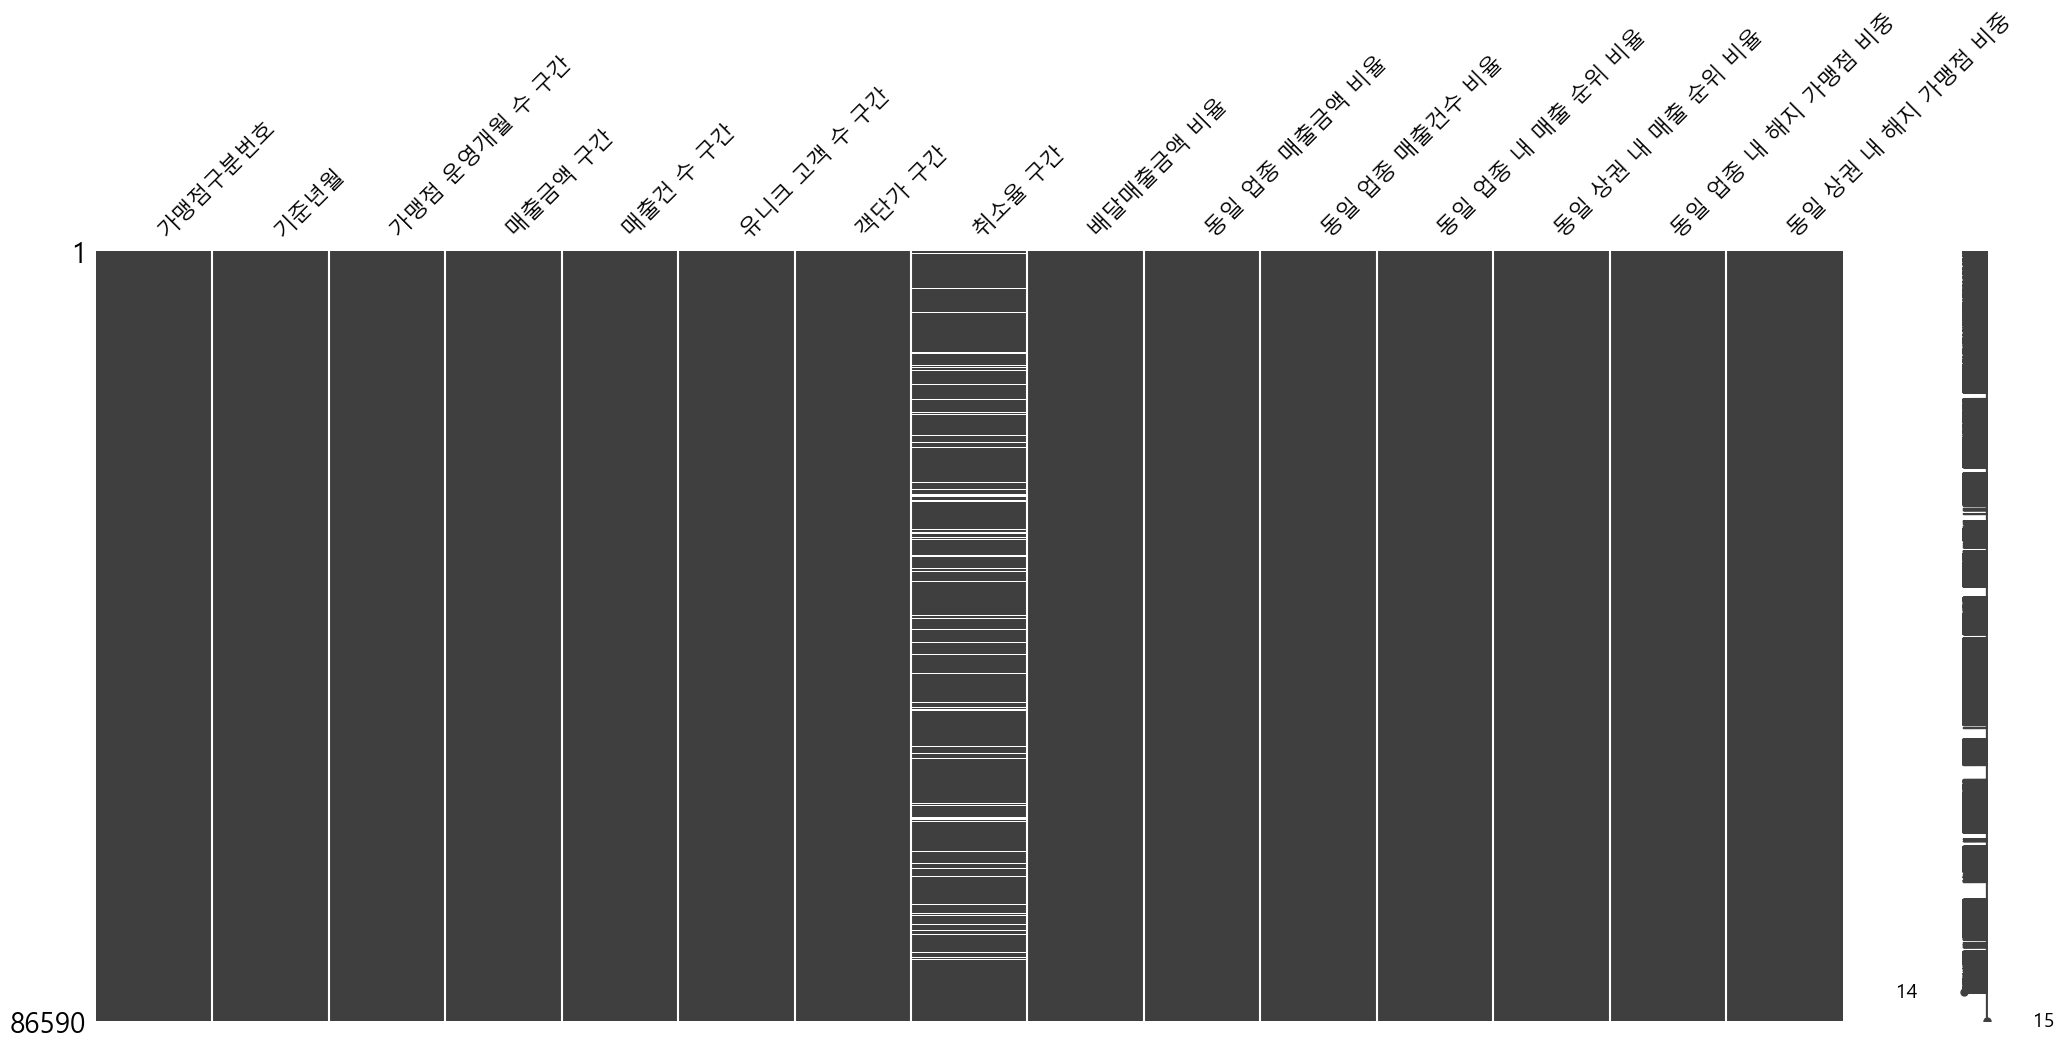

In [22]:
import missingno as msno
msno.matrix(df_sales)

In [24]:
print(f"처리 전 결측값 개수: {df_sales['취소율 구간'].isnull().sum()}")

# 가맹점구분번호에서 취소율 구간 최빈값 이용해 결측치 처리
cancel_rate_mode_map = df_sales.groupby('가맹점구분번호')['취소율 구간'].agg(lambda x: x.mode()[0])
fill_values = df_sales['가맹점구분번호'].map(cancel_rate_mode_map)
df_sales['취소율 구간'].fillna(fill_values, inplace=True)

print(f"처리 후 결측값 개수: {df_sales['취소율 구간'].isnull().sum()}")

처리 전 결측값 개수: 6632
처리 후 결측값 개수: 0


In [25]:
#  0,1에 가까울 수록 상위
# '취소율 구간'은 (취소율 낮음)
columns_to_process = [
    '가맹점 운영개월 수 구간',
    '매출금액 구간',
    '매출건 수 구간',
    '유니크 고객 수 구간',
    '객단가 구간',
    '취소율 구간'
]

for col in columns_to_process:
    df_sales[col] = df_sales[col].str.split('_').str[0].astype(int)


In [26]:
df_info.to_csv('./data/df_info1.csv', encoding='utf-8-sig', index=False)

df_sales.to_csv('./data/df_sales1.csv', encoding='utf-8-sig', index=False)

df_customer.to_csv('./data/df_customer1.csv', encoding='utf-8-sig', index=False)
